In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import rankdata

In [2]:
sc = "Datasets/IDPCDU_Edges/set1/"
TaskNames = os.listdir(sc)
TaskNames.sort()

for i in range(24):
    print(i, TaskNames[i])

0 idpc_10x10x1000.idpc
1 idpc_10x20x2713.idpc
2 idpc_10x5x425.idpc
3 idpc_15x15x3375.idpc
4 idpc_15x30x12111.idpc
5 idpc_15x7x1504.idpc
6 idpc_20x10x2492.idpc
7 idpc_20x20x8000.idpc
8 idpc_20x40x26104.idpc
9 idpc_25x12x4817.idpc
10 idpc_25x25x15625.idpc
11 idpc_25x50x57147.idpc
12 idpc_30x15x10025.idpc
13 idpc_30x30x27000.idpc
14 idpc_30x60x89772.idpc
15 idpc_35x17x13934.idpc
16 idpc_35x35x42875.idpc
17 idpc_35x70x123585.idpc
18 idpc_40x20x18485.idpc
19 idpc_40x40x64000.idpc
20 idpc_40x80x130681.idpc
21 idpc_45x22x43769.idpc
22 idpc_45x45x91125.idpc
23 idpc_45x90x322081.idpc


In [3]:
from build_g_domain import AlgorithmV1 

def Load_data(taskIDs):
    Tasks = [0, 0]
    MAX_DIM = 0
    NUM_TASK = 2
    MAX_NODE = 0

    for i in range(2):
        path = sc + TaskNames[taskIDs[i]] 
        Tasks[i] = AlgorithmV1(path,name=TaskNames[taskIDs[i]])
        MAX_DIM = max(MAX_DIM, Tasks[i].NUM_DOMAIN)
        MAX_NODE = max(MAX_NODE, Tasks[i].NUM_NODE)

    return Tasks, NUM_TASK, MAX_DIM,MAX_NODE

In [4]:
Tasks, NUM_TASK, MAX_DIM,MAX_NODE = Load_data([5,6])

In [5]:
def GeneratorIndiv(dims=MAX_DIM, edge_dim = MAX_NODE):
    domain = np.random.permutation(range(1,dims+1))
    edge = np.random.randint(edge_dim, size=dims)
    indiv = np.array([domain,edge])

    fac_cost = []
    for task in Tasks:
        # print(task.Cost(indiv))
        fac_cost.append(task.Cost(indiv))
    
    return indiv, fac_cost

In [6]:
def Generate_Eval(sizePop, d = MAX_DIM):
    population = []
    pop_cost = []
    for i in range(sizePop):
        pi, f_cost = GeneratorIndiv(d)
        population.append(pi)
        pop_cost.append(f_cost)
    population,pop_cost = np.asarray(population),np.asarray(pop_cost)
    rank = rankdata(pop_cost,axis=0)
    return population,pop_cost,rank

In [7]:
def heSo(n,m,TH=0.4):
    # a1 + b1 = 1
    # a1*m+b1 = TH
    # a2*m + b2= TH
    # a2*n + b2 = 0
    a1 = (1-TH)/(1-m + 1e-6)
    b1 = 1 - a1
    a2 = TH/(m-n + 1e-6)
    b2 = (TH-a2*m)
    return a1,b1,a2,b2
def fm(a1,b1,a2,b2,n,m,r,TH=0.4):
    if r >= 1 and r <= m:
        return a1*r+b1
    else:
        return a2*r+b2

In [8]:
def abilitiVector(rank,TH,n,m):
    a1,b1,a2,b2 = heSo(n,m,TH)
    abiVector =[]
    for x in range(len(rank)):
        df =[]
        for item in rank[x]:
            df.append(fm(a1,b1,a2,b2,n,m,item,TH))
        abiVector.append(df)
    return np.array(abiVector)

In [9]:
def mutation(individual, e = 0.15):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    res[index1] -= e
    res[index2] += e

    return res

In [10]:
def paradox_mutationItem(ind):
    indiv = np.copy(ind)
    n = len(indiv)
    index1 = 0
    index2 = np.random.randint(n)

    while index1 < index2:
        temp = indiv[index1]
        indiv[index1] = indiv[index2]
        indiv[index2] = temp
        index1 += 1
        index2 -= 1

    return indiv

In [11]:
def paradox_mutation(indiv):
    res = []
    for item in indiv:
        res.append(paradox_mutationItem(item))
    return res

In [12]:
def cut_only_item(p1, p2):
    index = np.random.randint(p1.shape[0])
    o1 = list(p1[:index]) + list(p2[index:])
    o2 = list(p2[:index]) + list(p1[index:])
    return o1,o2
def cut_only(p1,p2):
    a,b = cut_only_item(p1[0],p2[0])
    c,d= cut_only_item(p1[1],p2[1])
    return np.array([a,c]),np.array([b,d])

In [13]:
def mutation_swap(individual):

    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(5)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    temp = res[index1]
    res[index1] = res[index2]
    res[index2] = temp

    return res

In [14]:
def cross_pmx_item(p1, p2):
    n = len(p1)
    l = int(n/3)
    
    index1 = np.random.randint(l)
    index2 = np.random.randint(l+l, 3*l)

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2

def cross_pmx(p1,p2):
    a,b = cross_pmx_item(p1[0],p2[0])
    c,d= cut_only_item(p1[1],p2[1])
    return np.array([a,c]),np.array([b,d])

In [15]:
def Offspring_Generation(pop,abiVector,task,Pa,Pb,m):
    n = pop.shape[0]
    x_star = pop[abiVector[:,task].argmax()]
    offs_gen = []
    abi_gen = []
    for indiv in range(int(m/2)):
        index1 = np.random.randint(n)
        while True:
            index2 = np.random.randint(n)
            if index1 != index2: break
        p1,p2 = pop[index1],pop[index2]

        if np.random.random_sample() < Pa:
            c1,c2 = cross_pmx(p1,p2)


            if np.random.random_sample() < Pb:


                x1 = mutation_swap(c1[0])
                x2 = mutation_swap(c2[0])


                x3 = mutation_swap(c1[1])
                x4 = mutation_swap(c2[1])

                c1 = np.array([x1,x3])
                c2 = np.array([x2,x4])
        else:
            c1 = paradox_mutation(p1)
            c2 = paradox_mutation(p2)
            c1 = np.array(c1)
            c2 = np.array(c2)


        if np.random.random_sample() < 0.5:
            a1 = abiVector[index1]
            a2 = abiVector[index2]
        else:
            a1 = abiVector[index2]
            a2 = abiVector[index1]
        
        offs_gen.append(c1)
        offs_gen.append(c2)
        abi_gen.append(a1)
        abi_gen.append(a2)
    # return offs_gen,abi_gen
    return np.array(offs_gen), np.array(abi_gen) 

In [16]:
MAX = np.inf

In [17]:
def updateAbility(pop_cost,TH,n,m):
    rank = rankdata(pop_cost,axis=0)
    abiVector = abilitiVector(rank,TH,n,m)
    return abiVector

In [18]:
from tqdm import tqdm

In [19]:
def selectNewPop(pop,pop_cost,off_gen,off_fc,k):
    tmp = np.arange(off_gen.shape[0])
    random.shuffle(tmp)
    new_pop = []
    new_cost = []
    for task in range(k):
        index = pop_cost[:,task].argmin()
        new_pop.append([pop[index]])
        new_cost.append([pop_cost[index]])
    new_pop.append(off_gen[tmp[:-2]])
    new_cost.append(off_fc[tmp[:-2]])
    return np.concatenate(new_pop), np.concatenate(new_cost)

In [20]:
def Select_Eval(offs_gen,abi_gen,task,k):
    size_gen = offs_gen.shape[0]
    tmp = np.arange(size_gen)
    random.shuffle(tmp)
    
    new_gen = []
    new_fc = []
    for x in tmp:
        indiv = offs_gen[x]
        abi_x = abi_gen[x]
        fc = []
        for js in range(k):
            if js == task or np.random.random_sample() <= abi_x[js]:
                # print('indiv',indiv)
                cost = Tasks[js].Cost(indiv)
            else:
                cost = MAX
            fc.append(cost)
        new_fc.append(fc)
        new_gen.append(indiv)
    return np.array(new_gen),np.array(new_fc)

In [21]:
def SREMTO(n,TH,Pa,Pb,epochs=200):
    population,pop_cost,rank = Generate_Eval(n)
    k = len(Tasks)
    m = int(n/k)
    abiVector = abilitiVector(rank,TH,n,m)
    
    log = []
    KTI = []
    # per = int(m*3/5)
    # print('per',per)
    for epoch in tqdm(range(epochs)):
        off_gen = []
        off_fc = []
        for task in range(k):
            # print(abiVector[:,task])
            index = abiVector[:,task].argsort()[-m:][::-1]
            # print(index)
            if task == 0:
                setA = set(index)
            elif task == 1:
                setB = set(index)
            # print(population[index[:per]])
            # group = [population[index[:per]],pop_cost[index[:per]],rank[index[:per]],abiVector[index[:per]]]
            group = [population[index],pop_cost[index],rank[index],abiVector[index]]

            
            offs_gen,abi_gen = Offspring_Generation(group[0],group[3],task,Pa,Pb,m)
            
            new_gen,new_fc = Select_Eval(offs_gen,abi_gen,task,k)

            off_gen.append(new_gen)
            off_fc.append(new_fc)
            
            # off_gen.append(new_gen)
            # off_gen.append(population[index[per:]])
            # off_fc.append(new_fc)
            # off_fc.append(pop_cost[index[per:]])
        KTI.append(len(setA.intersection(setB))/m)

        
        
        off_gen = np.concatenate(off_gen)
        off_fc = np.concatenate(off_fc)
        # return off_gen,off_fc
 
        
        population = np.concatenate([population,off_gen],axis=0)
        pop_cost = np.concatenate([pop_cost,off_fc],axis=0)
        
        #update
        # tmp_pop = []
        # tmp_cost = []
        listIndex = []
        for task in range(k):
            index = pop_cost[:,task].argsort()
            if task == 0:
                listIndex.extend(index[:m])
            elif task == 1:
                iter = 0
                for i in index:
                    if iter < m and i not in listIndex:
                        # print(i)
                        listIndex.extend([i])
                        iter +=1
        population = population[listIndex]
        pop_cost = pop_cost[listIndex]
        abiVector = updateAbility(pop_cost,TH,n,m)

        # population,pop_cost = selectNewPop(population,pop_cost,off_gen,off_fc,2)
        # abiVector = updateAbility(pop_cost,TH,n,m)
        
        best = []
        for task in range(k):
            cost = pop_cost[:,task].min()
            # cost = pop_cost[index,task]
            best.append(cost)
        log.append(best)
    return np.array(log),KTI

In [22]:
log_seeds = []


for i in range(3):
    np.random.seed(i)
    random.seed(i)
    Tasks[0].best = np.inf
    Tasks[0].indivi_best = []
    Tasks[1].best = np.inf
    Tasks[1].indivi_best = []

    log,KTI = SREMTO(100,0.7,0.7,0.6,epochs=100)
    # population,pop_cost,rank,abiVector =  SREMTO(100,0.7,0.7,1,epochs=1000)
    log_seeds.append(log)

100%|██████████| 100/100 [00:02<00:00, 38.70it/s]


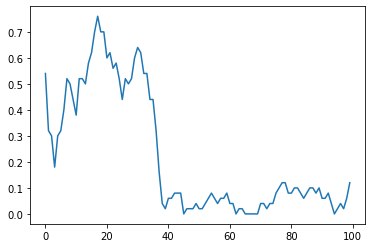

In [23]:
plt.plot(range(len(KTI)),KTI)
plt.show()

In [24]:
k = len(Tasks)

In [25]:
def show(log,stt):
    plt.figure(figsize=(10, 50))
    for i in range(k):
        name = str(Tasks[i].NUM_NODE) + ' x '+ str(Tasks[i].NUM_DOMAIN)
        plt.subplot(12,2,i+1)
        best = log[:,i].min()
        plt.plot(log[:,i])
        plt.title('IDPCU {i} best: {best}'.format(i=name.upper(),best=best))
    plt.show()

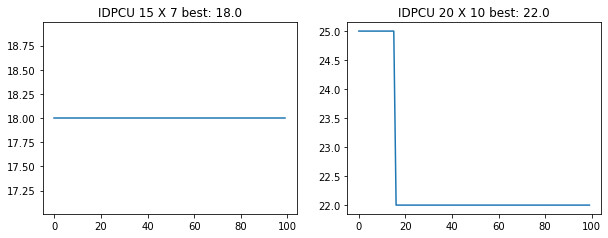

In [26]:
show(log,'12')

In [27]:
log_seeds = np.concatenate(log_seeds)

In [28]:
log_seeds.min(axis=0)

array([18., 22.])

In [29]:
np.average(log_seeds,0)

array([18.        , 22.91333333])

In [30]:
log_seeds.max(axis=0)

array([18., 25.])

In [31]:
import random

random_number = random.randint(1, 2)
print(random_number)

2
